In [2]:
# Cell 1: Setup and imports
import os
import numpy as np
import cv2
import imutils
import shutil
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet101

In [3]:
# Cell 2: GPU configuration
# Ensure TensorFlow uses the correct GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth to avoid using all GPU memory at once
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
            
        # Optionally, limit the total memory usage to 50% of the GPU's capacity
        tf.config.experimental.set_virtual_device_configuration(
            physical_devices[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=physical_devices[0].memory_limit * 0.5)]
        )
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialize

In [4]:
# Cell 3: Print versions
print("Keras version: ", tf.keras.__version__)
print("TensorFlow version: ", tf.__version__)

Keras version:  3.4.1
TensorFlow version:  2.17.0


In [5]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print("No contours found.")
        return image

    c = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(c) < 500:
        print("Contour area too small.")
        return image

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')
        plt.show()

    return new_image

4


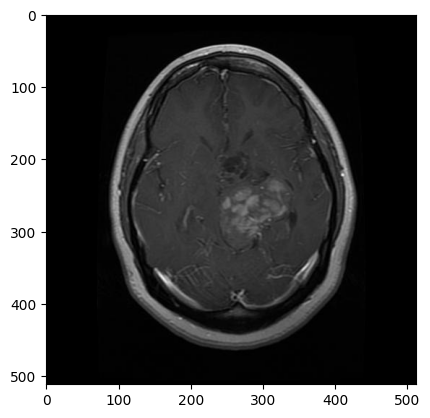

(512, 512, 3)


In [6]:
dataset_path = 'Brain_Tumor_Dataset'
folder_names = [f for f in sorted(os.listdir(dataset_path))]
print(len(folder_names))

image_path = r"D:\Purva\Coding\Jupyter\Project\Brain_Tumor_Dataset\glioma_tumor\gg (1).jpg"
image = cv2.imread(image_path)
if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()
else:
    print(f"Failed to load image from {image_path}")

print(image.shape)


In [7]:
# Cell 6: Check folder names and categories
folder_names = ["Glioma_Tumor","Meningioma_Tumor","Pituitary_Tumor","No_Tumor"]
categories_selected = [0, 1, 2, 3]

print(f'Length of folder_names: {len(folder_names)}')
print(f'Length of categories_selected: {len(categories_selected)}')
print(f'Categories selected: {categories_selected}')

if all(i < len(folder_names) for i in categories_selected):
    print('Selected categories:')
    print([folder_names[i] for i in categories_selected])
else:
    print("One or more indices in categories_selected are out of range.")


Length of folder_names: 4
Length of categories_selected: 4
Categories selected: [0, 1, 2, 3]
Selected categories:
['Glioma_Tumor', 'Meningioma_Tumor', 'Pituitary_Tumor', 'No_Tumor']


Dataset path: Brain_Tumor_Dataset
Folder names: ['Glioma_Tumor', 'Meningioma_Tumor', 'Pituitary_Tumor', 'No_Tumor']
Checking folder path: Brain_Tumor_Dataset\Glioma_Tumor
Loading image: Brain_Tumor_Dataset\Glioma_Tumor\gg (1).jpg


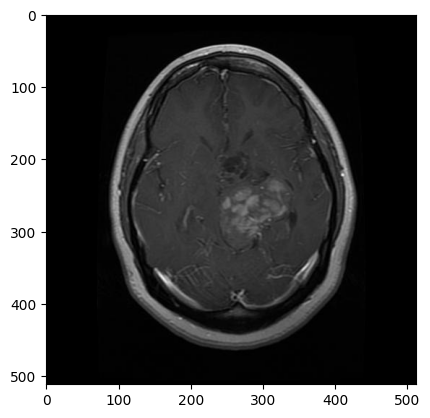

Loading image: Brain_Tumor_Dataset\Glioma_Tumor\gg (10).jpg


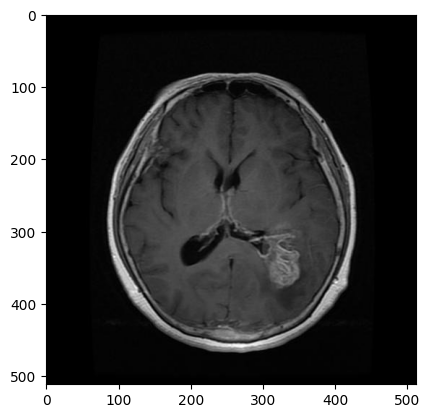

Loading image: Brain_Tumor_Dataset\Glioma_Tumor\gg (100).jpg


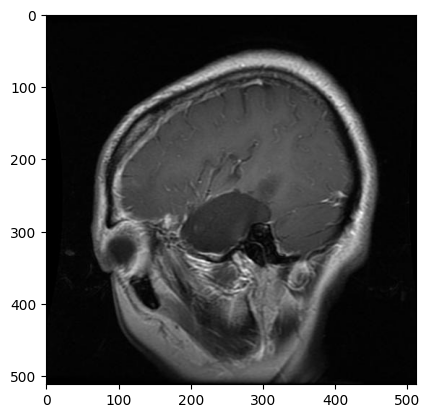

Loading image: Brain_Tumor_Dataset\Glioma_Tumor\gg (101).jpg


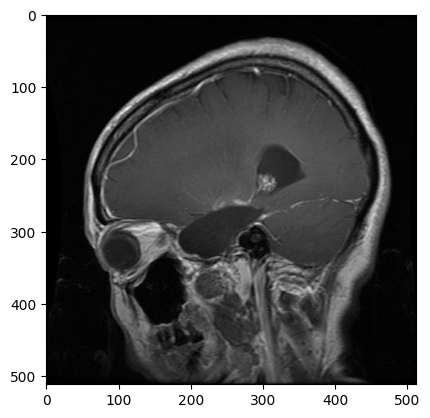

Loading image: Brain_Tumor_Dataset\Glioma_Tumor\gg (102).jpg


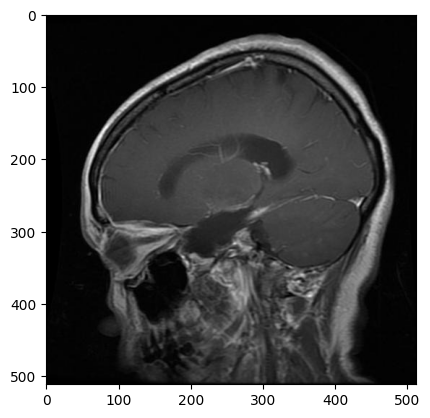

Checking folder path: Brain_Tumor_Dataset\Meningioma_Tumor
Loading image: Brain_Tumor_Dataset\Meningioma_Tumor\m (10).jpg


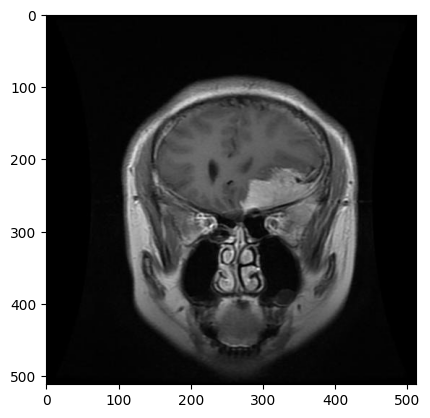

Loading image: Brain_Tumor_Dataset\Meningioma_Tumor\m (100).jpg


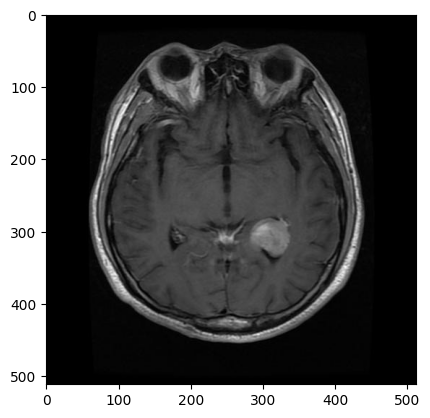

Loading image: Brain_Tumor_Dataset\Meningioma_Tumor\m (101).jpg


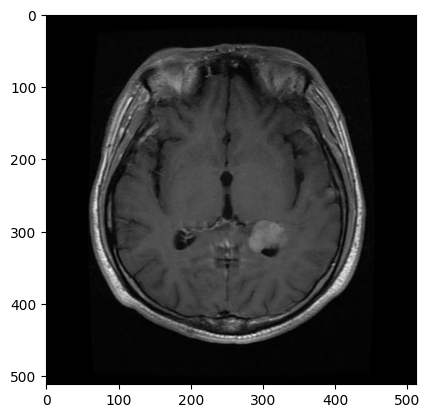

Loading image: Brain_Tumor_Dataset\Meningioma_Tumor\m (102).jpg


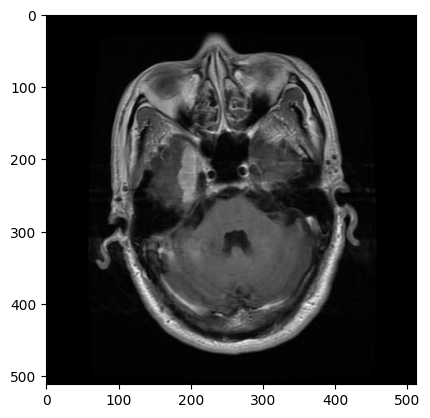

Loading image: Brain_Tumor_Dataset\Meningioma_Tumor\m (103).jpg


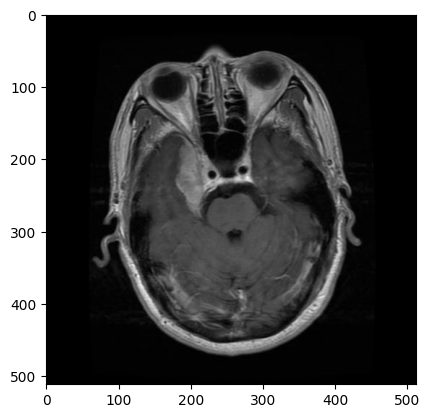

Checking folder path: Brain_Tumor_Dataset\Pituitary_Tumor
Loading image: Brain_Tumor_Dataset\Pituitary_Tumor\p (1).jpg


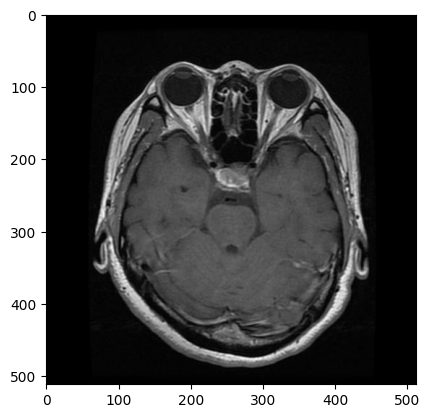

Loading image: Brain_Tumor_Dataset\Pituitary_Tumor\p (10).jpg


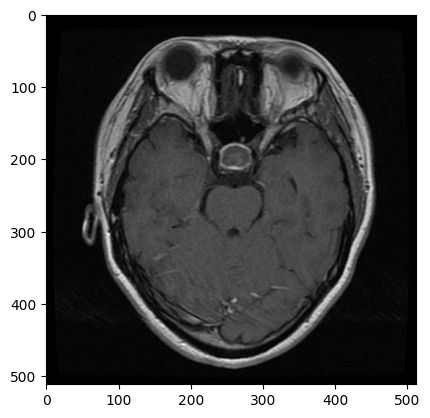

Loading image: Brain_Tumor_Dataset\Pituitary_Tumor\p (100).jpg


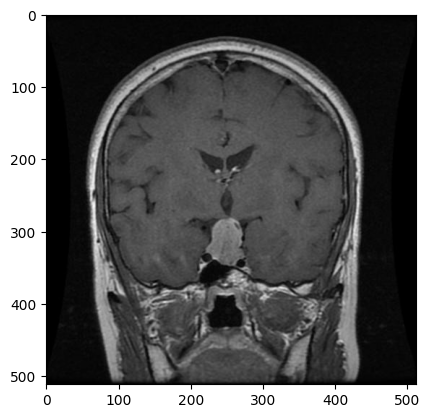

Loading image: Brain_Tumor_Dataset\Pituitary_Tumor\p (101).jpg


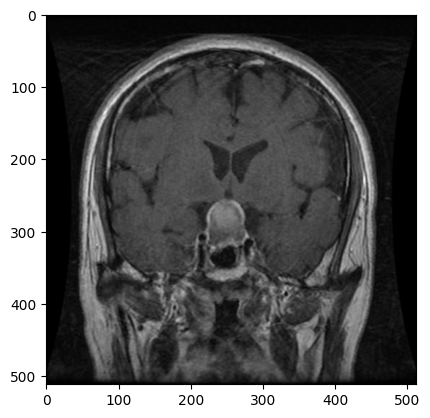

Loading image: Brain_Tumor_Dataset\Pituitary_Tumor\p (102).jpg


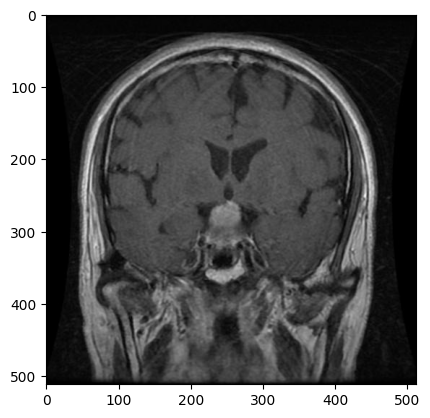

Checking folder path: Brain_Tumor_Dataset\No_Tumor
Loading image: Brain_Tumor_Dataset\No_Tumor\1.jpg


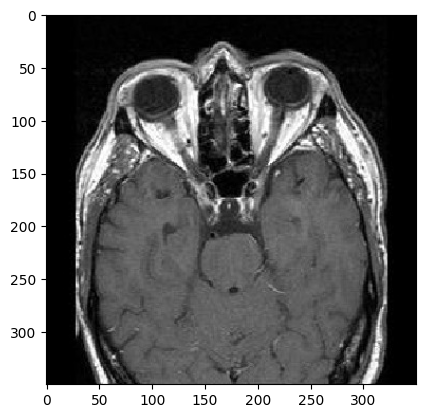

Loading image: Brain_Tumor_Dataset\No_Tumor\2.jpg


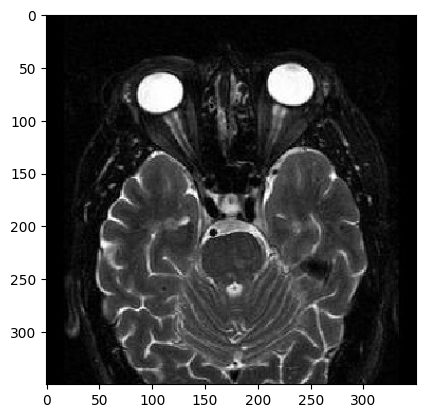

Loading image: Brain_Tumor_Dataset\No_Tumor\3.jpg


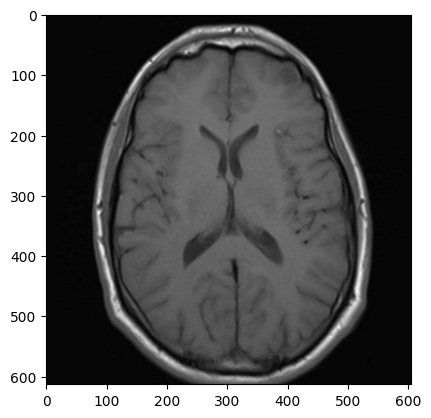

Loading image: Brain_Tumor_Dataset\No_Tumor\4.jpg


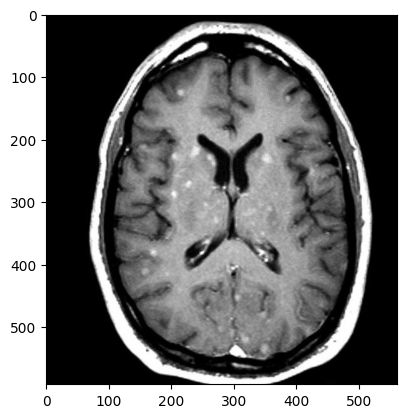

Loading image: Brain_Tumor_Dataset\No_Tumor\5.jpg


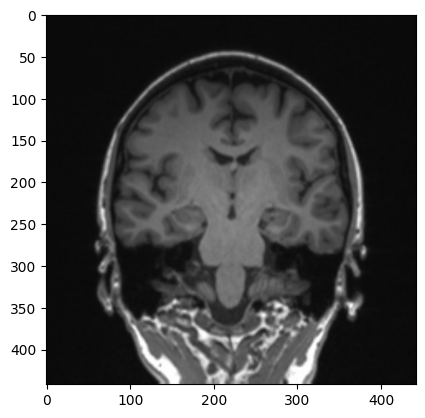

In [8]:
# Cell 7: Load and display images from each category
images_number = 5
print(f'Dataset path: {dataset_path}')
print(f'Folder names: {folder_names}')

for category in categories_selected:
    folder_path = os.path.join(dataset_path, folder_names[category])
    print(f'Checking folder path: {folder_path}')
    try:
        image_names = [img for img in sorted(os.listdir(folder_path))][:images_number]
        for j, image_name in enumerate(image_names):
            image_path = os.path.join(folder_path, image_name)
            print(f'Loading image: {image_path}')
            image = cv2.imread(image_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(image_rgb)
                plt.show()
            else:
                print(f'Failed to load image: {image_path}')
    except FileNotFoundError:
        print(f'Folder not found: {folder_path}')


In [9]:
# Cell 8: Split dataset into train, validation, and test sets
dataset_path = r"D:\Purva\Coding\Jupyter\Project\Brain_Tumor_Dataset"
folder_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor' , 'pituitary_tumor'] 

category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}
total_images = 0

for i, category in enumerate(folder_names):
    category_dict[i] = category
    folder_path = dataset_path + '/' + category
    image_names = [img for img in sorted(os.listdir(folder_path))]
    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names
    print('%s: %d' %(category, images_per_category_dict[i]))
    total_images += images_per_category_dict[i]

print('Total images in dataset: %d' %(total_images))

base_path = './split_dataset10'

try:
    os.mkdir(base_path)
except FileExistsError:
    print(f"The directory {base_path} already exists.")

train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')

for directory in [train_dir, validation_dir, test_dir]:
    for category in folder_names:
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            os.mkdir(category_path)
        else:
            print(f"Directory {category_path} already exists.")

total_train = 0
total_validation = 0
total_test = 0

total_train_2 = 0
total_validation_2 = 0
total_test_2 = 0

for i, category in enumerate(folder_names):
    train_number = int(0.7 * images_per_category_dict[i])
    validation_number = int(0.2 * images_per_category_dict[i])
    test_number = images_per_category_dict[i] - train_number - validation_number
    total_train += train_number
    total_validation += validation_number
    total_test += test_number

    fnames = category_images_path_dict[i][:train_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(train_dir, category, fname)
        shutil.copyfile(src, dst)
    total_train_2 += len(fnames)

    fnames = category_images_path_dict[i][train_number:train_number + validation_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(validation_dir, category, fname)
        shutil.copyfile(src, dst)
    total_validation_2 += len(fnames)

    fnames = category_images_path_dict[i][train_number + validation_number:]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(test_dir, category, fname)
        shutil.copyfile(src, dst)
    total_test_2 += len(fnames)

print('Correct train split: ', total_train == total_train_2)
print('Correct validation split: ', total_validation == total_validation_2)
print('Correct test split: ', total_test == total_test_2)
print('Number of training images: ', total_train)
print('Number of validation images: ', total_validation)
print('Number of test images: ', total_test)
print('Real percentage of training images: ', total_train / total_images)
print('Real percentage of validation images: ', total_validation / total_images)
print('Real percentage of test images: ', total_test / total_images)

glioma_tumor: 826
meningioma_tumor: 822
no_tumor: 395
pituitary_tumor: 827
Total images in dataset: 2870
The directory ./split_dataset10 already exists.
Directory ./split_dataset10\train\glioma_tumor already exists.
Directory ./split_dataset10\train\meningioma_tumor already exists.
Directory ./split_dataset10\train\no_tumor already exists.
Directory ./split_dataset10\train\pituitary_tumor already exists.
Directory ./split_dataset10\validation\glioma_tumor already exists.
Directory ./split_dataset10\validation\meningioma_tumor already exists.
Directory ./split_dataset10\validation\no_tumor already exists.
Directory ./split_dataset10\validation\pituitary_tumor already exists.
Directory ./split_dataset10\test\glioma_tumor already exists.
Directory ./split_dataset10\test\meningioma_tumor already exists.
Directory ./split_dataset10\test\no_tumor already exists.
Directory ./split_dataset10\test\pituitary_tumor already exists.
Correct train split:  True
Correct validation split:  True
Correct

In [10]:
# Cell 9: Define the CNN model with Transfer Learning
conv_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

In [11]:
# Cell 10: Compile the model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


In [12]:
# Cell 11: Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2007 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [15]:
# Cell 12: Train the model for more epochs
history = model.fit(
    train_generator,
    steps_per_epoch=150,
    epochs=15,  # Increased number of epochs
    validation_data=validation_generator,
    validation_steps=30
)

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 435ms/step - acc: 0.8264 - loss: 0.4318 - val_acc: 0.6492 - val_loss: 1.0048
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 433ms/step - acc: 0.8467 - loss: 0.4237 - val_acc: 0.6684 - val_loss: 0.8868
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 433ms/step - acc: 0.8438 - loss: 0.4055 - val_acc: 0.6422 - val_loss: 0.9760
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 436ms/step - acc: 0.8470 - loss: 0.3923 - val_acc: 0.6161 - val_loss: 1.0142
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 436ms/step - acc: 0.8417 - loss: 0.4223 - val_acc: 0.6056 - val_loss: 0.9772
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 442ms/step - acc: 0.8537 - loss: 0.3845 - val_acc: 0.6649 - val_loss: 0.9248
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 441ms/step - acc: 0.8440 - loss: 0.3824 - val_acc: 0.6545 - val_loss: 0.9918
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 434ms/step - acc: 0.8472 - loss: 0.3780 - val_acc: 0.7260 - val_loss: 0.7410
Epoch 9/15
150/150 ━━━━━━━━━━━━━

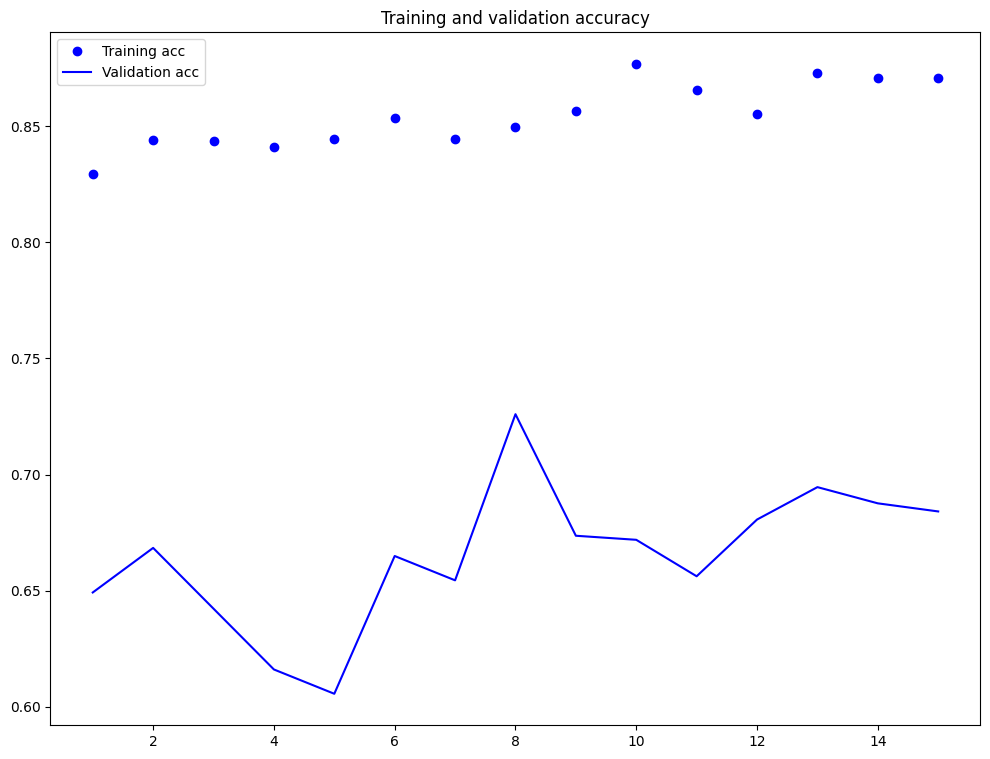

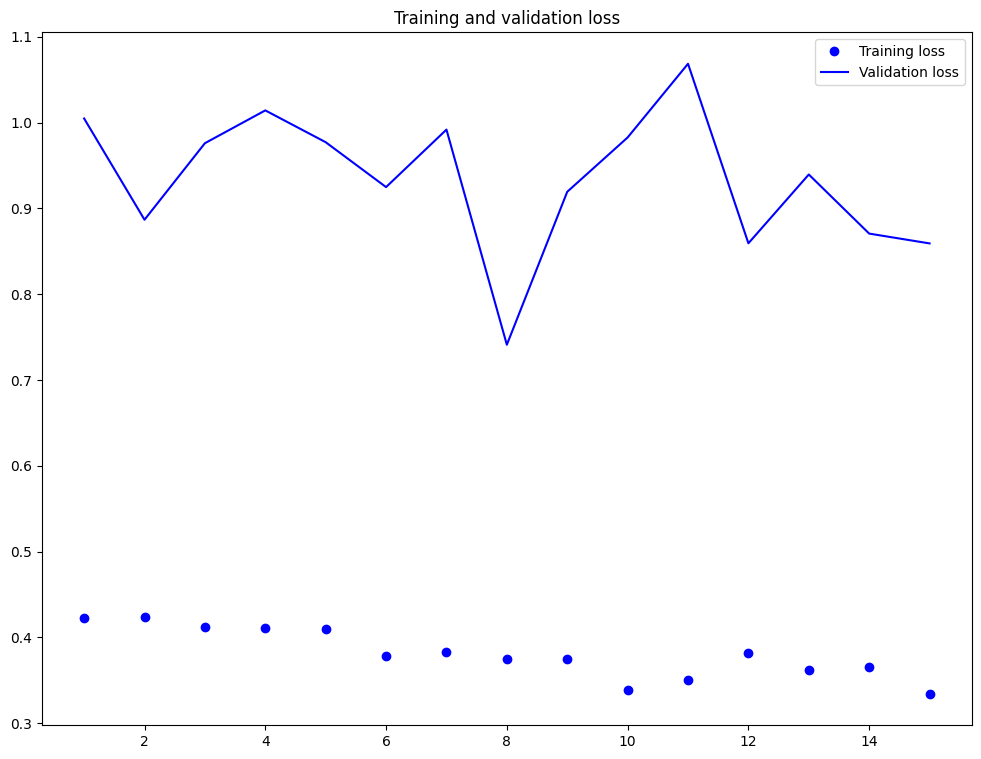

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()